Google Earth Engine
Era 5 data
---

The data was presumably retrieved. I fumbled the handle. Let's redo it here.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

#the reversed map coordinates refers to the 
#call to earth engine, not the result
east_coast_tiff = '../weather-data/era5/ERA5_Temperature_TimeSeries_NY_eastcoast.tif'
TIFF_file_path = '../weather-data/era5/ERA5_Temperature_TimeSeries_NWMass_native_31km_reversedmapcoordinates.tif'

#load two images. src_data is the data of interest.
#the east_coast is an easier to see example
with rasterio.open(TIFF_file_path) as src:
    src_data = src.read()
with rasterio.open(east_coast_tiff) as src:
    east_coast = src.read()

#the data is numpy arrays of images
#each image is an hour apart
print('time, lats, lons')
print(src_data.shape)
print(east_coast.shape)

time, lat, lon
(169, 8, 10)
(169, 602, 845)


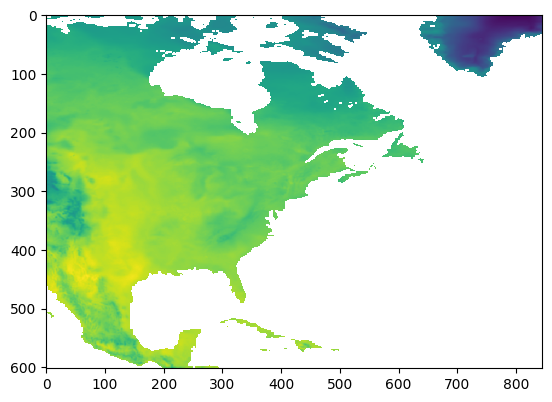

In [9]:
#a lot of the (time) images in east_coast are nans.
#for the Massachusetts data, the first image is nan

#take a look at one of the east coast images.
plt.imshow(east_coast[1])

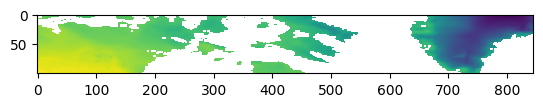

In [10]:
#the indices are [time, row (latitude), column (longitude)]
#show only a slice of latitudes
plt.imshow(east_coast[1,:100,:])

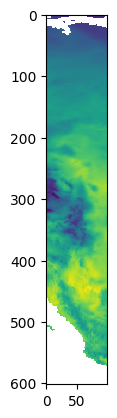

In [11]:
#the indices are [time, row (latitude), column (longitude)]
#show only a slice of longitudes
plt.imshow(east_coast[1,:,:100])

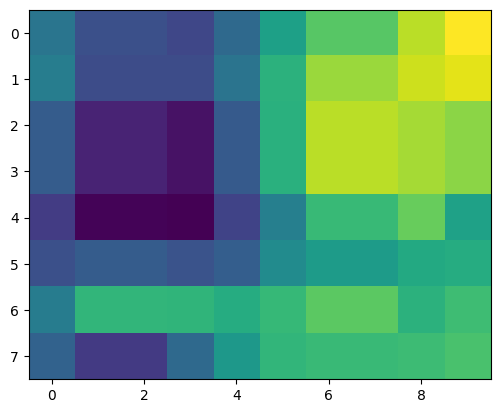

In [12]:
#take a look at one of the massachusetts data.
#this was made by asking google earth engine for era5 hourly data from sept 19-25
#this was originally performed on 9/30, but era5 data lags by 5 days.

#the given point was lat, lon [42.5, -72.768], with a 30km region of interest.
#the native resolution of era5 is 9km.
#since the data is so chunky, too, I suspect it gives you enough pixels in each direction
#to cover the distance given, erring on the side of giving extra.

#So I will for now assume the defined center point is somewhere in the central 4 squares,
#src[3:5,4:6].
plt.imshow(src_data[1])

In [16]:
#The longitude might be squished for more northern points.
#look at this data overlayed on a map with folium.
import ee
ee.Authenticate()
ee.Initialize()
import folium

era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate('2024-09-18', '2024-09-30')
temp_data = era5.select('temperature_2m')
temperature = temp_data.mean().subtract(273.15)


# Define visualization parameters
vis_params = {
    'min': 8.5,
    'max': 23.5,
    'palette': ['blue', 'green', 'yellow', 'red']
}

# Create a map centered around Ashfield
map_center = [42.500,	-72.76800]
m = folium.Map(location=map_center, zoom_start=10)

# Add the temperature layer to the map using the folium and Earth Engine integration
folium.TileLayer(
    tiles=temperature.getMapId(vis_params)['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    opacity=0.6
).add_to(m)

# Display the map
m

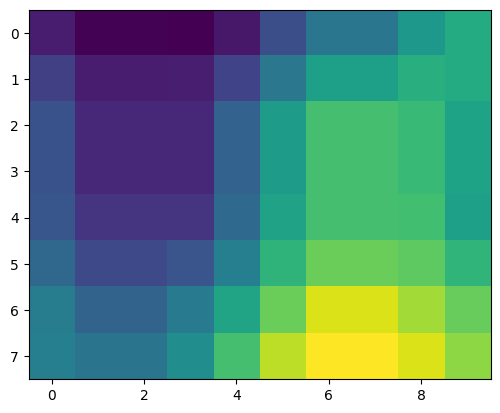

In [188]:
#returning to the src_data...
plt.imshow(src_data[-1])

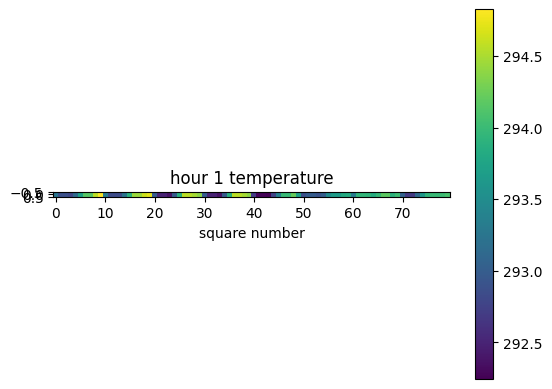

In [46]:
#We'll treat each square independently and see what fits best.

#see how reshaping the array stitches together the rows.
#this was my big error. I used a shape of (-1,169) for this in the previous notebook.
#each entry is still one hour, with all the different squares in that hour
src_reshaped = src_data.reshape((-1,80))
plt.imshow([src_reshaped[1]])     
# print(src_reshaped)
plt.title('hour 1 temperature')
plt.xlabel('square number')
plt.colorbar()

In [78]:
#assemble this into a date-wise dataframe.
#each column is the time series for one of the squares in the grid.
sStart_date = '2024-09-18'
sEnd_date = '2024-09-25'

#create the date index
dates = pd.date_range(start=sStart_date, end=sEnd_date, freq='h')

#create the dataframe
era5_by_date = pd.DataFrame(src_reshaped, index = dates)

#translate the times by subtracting 5 hours for EST.
#they are currently in UTC, and EST is 5 hours behind
#EST = (UTC-5:00)
from datetime import timedelta

era5_by_date.index = dates - timedelta(hours=5)

era5_by_date

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
2024-09-17 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-17 20:00:00,293.252777,292.873871,292.873871,292.789886,293.127777,293.715668,294.160980,294.160980,294.557465,294.826996,...,293.059418,292.688324,292.688324,293.129730,293.619965,293.946136,293.993011,293.993011,294.018402,294.090668
2024-09-17 21:00:00,291.494202,291.369202,291.369202,291.253967,291.578186,292.367249,292.793030,292.793030,293.150452,293.406311,...,291.828186,291.568420,291.568420,292.103577,292.628967,292.980530,293.023499,293.023499,292.925842,292.794983
2024-09-17 22:00:00,290.795929,291.342804,291.342804,290.887726,290.022491,290.676788,291.122101,291.122101,291.551788,292.055695,...,290.909210,290.842804,290.842804,290.944366,291.577179,291.954132,291.940460,291.940460,291.823273,291.672882
2024-09-17 23:00:00,290.603638,290.730591,290.730591,290.025513,289.025513,289.494263,290.242310,290.242310,291.013794,291.502075,...,289.732544,289.589966,289.589966,289.963013,290.625122,290.966919,290.951294,290.951294,290.802856,290.623169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24 15:00:00,289.741669,289.384247,289.384247,289.188934,289.227997,289.661591,290.046356,290.046356,290.395966,290.602997,...,289.685028,289.392059,289.392059,289.661591,290.274872,290.819794,291.120575,291.120575,291.052216,290.761200
2024-09-24 16:00:00,289.381348,289.043457,289.043457,288.873535,288.939941,289.404785,289.814941,289.814941,290.186035,290.406738,...,289.514160,289.277832,289.277832,289.582520,290.240723,290.832520,291.152832,291.152832,291.057129,290.730957
2024-09-24 17:00:00,288.515564,288.249939,288.249939,288.160095,288.306580,288.841736,289.302673,289.302673,289.722595,289.978455,...,288.945251,288.769470,288.769470,289.134705,289.849548,290.499939,290.843689,290.843689,290.705017,290.335876
2024-09-24 18:00:00,287.553589,287.340698,287.340698,287.317261,287.514526,288.051636,288.504761,288.504761,288.909058,289.153198,...,288.346558,288.200073,288.200073,288.547729,289.231323,289.852417,290.172729,290.172729,290.020386,289.647339


In [80]:
#upsample this to fit the 15 min rate of the live feed data
era5_by_upsampled_date = era5_by_date.resample('15min').interpolate()

In [82]:
#take the transpose to index by square number.
era5_by_square = era5_by_upsampled_date.T
era5_by_square.index.name = 'square'
era5_by_square

,2024-09-17 19:00:00,2024-09-17 19:15:00,2024-09-17 19:30:00,2024-09-17 19:45:00,2024-09-17 20:00:00,2024-09-17 20:15:00,2024-09-17 20:30:00,2024-09-17 20:45:00,2024-09-17 21:00:00,2024-09-17 21:15:00,...,2024-09-24 16:45:00,2024-09-24 17:00:00,2024-09-24 17:15:00,2024-09-24 17:30:00,2024-09-24 17:45:00,2024-09-24 18:00:00,2024-09-24 18:15:00,2024-09-24 18:30:00,2024-09-24 18:45:00,2024-09-24 19:00:00
square,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,293.252777,292.813141,292.373474,291.933838,291.494202,291.319641,...,288.731995,288.515564,288.275085,288.034576,287.794067,287.553589,287.269836,286.986084,286.702332,286.418579
1,NaN,NaN,NaN,NaN,292.873871,292.497711,292.121521,291.745361,291.369202,291.362610,...,288.448303,288.249939,288.022644,287.795319,287.567993,287.340698,287.058899,286.777100,286.495300,286.213501
2,NaN,NaN,NaN,NaN,292.873871,292.497711,292.121521,291.745361,291.369202,291.362610,...,288.448303,288.249939,288.022644,287.795319,287.567993,287.340698,287.058899,286.777100,286.495300,286.213501
3,NaN,NaN,NaN,NaN,292.789886,292.405914,292.021912,291.637939,291.253967,291.162415,...,288.338440,288.160095,287.949402,287.738678,287.527954,287.317261,287.035950,286.754639,286.473328,286.192017
4,NaN,NaN,NaN,NaN,293.127777,292.740387,292.352966,291.965576,291.578186,291.189270,...,288.464905,288.306580,288.108582,287.910553,287.712524,287.514526,287.232727,286.950928,286.669128,286.387329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NaN,NaN,NaN,NaN,293.946136,293.704742,293.463318,293.221924,292.980530,292.723938,...,290.583069,290.499939,290.338074,290.176178,290.014282,289.852417,289.611633,289.370850,289.130066,288.889282
76,NaN,NaN,NaN,NaN,293.993011,293.750641,293.508240,293.265869,293.023499,292.752747,...,290.920959,290.843689,290.675964,290.508209,290.340454,290.172729,289.925598,289.678467,289.431335,289.184204
77,NaN,NaN,NaN,NaN,293.993011,293.750641,293.508240,293.265869,293.023499,292.752747,...,290.920959,290.843689,290.675964,290.508209,290.340454,290.172729,289.925598,289.678467,289.431335,289.184204


In [83]:
#each entry in era5_by_square should be given a row, column, latitude, longitude.

#the first 10 squares are in row 0, second 10 in row 1, etc...

num_rows = 8
num_cols = 10

rows = [
   [row_number]*num_cols
    for row_number in range(num_rows)
]

cols = [
    [col_number for col_number in range(num_cols)]
    for row in range(num_rows)
]

era5_by_square['row'] = np.concatenate(rows)
era5_by_square['col'] = np.concatenate(cols)

era5_by_square

,2024-09-17 19:00:00,2024-09-17 19:15:00,2024-09-17 19:30:00,2024-09-17 19:45:00,2024-09-17 20:00:00,2024-09-17 20:15:00,2024-09-17 20:30:00,2024-09-17 20:45:00,2024-09-17 21:00:00,2024-09-17 21:15:00,...,2024-09-24 17:15:00,2024-09-24 17:30:00,2024-09-24 17:45:00,2024-09-24 18:00:00,2024-09-24 18:15:00,2024-09-24 18:30:00,2024-09-24 18:45:00,2024-09-24 19:00:00,row,col
square,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,293.252777,292.813141,292.373474,291.933838,291.494202,291.319641,...,288.275085,288.034576,287.794067,287.553589,287.269836,286.986084,286.702332,286.418579,0,0
1,NaN,NaN,NaN,NaN,292.873871,292.497711,292.121521,291.745361,291.369202,291.362610,...,288.022644,287.795319,287.567993,287.340698,287.058899,286.777100,286.495300,286.213501,0,1
2,NaN,NaN,NaN,NaN,292.873871,292.497711,292.121521,291.745361,291.369202,291.362610,...,288.022644,287.795319,287.567993,287.340698,287.058899,286.777100,286.495300,286.213501,0,2
3,NaN,NaN,NaN,NaN,292.789886,292.405914,292.021912,291.637939,291.253967,291.162415,...,287.949402,287.738678,287.527954,287.317261,287.035950,286.754639,286.473328,286.192017,0,3
4,NaN,NaN,NaN,NaN,293.127777,292.740387,292.352966,291.965576,291.578186,291.189270,...,288.108582,287.910553,287.712524,287.514526,287.232727,286.950928,286.669128,286.387329,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NaN,NaN,NaN,NaN,293.946136,293.704742,293.463318,293.221924,292.980530,292.723938,...,290.338074,290.176178,290.014282,289.852417,289.611633,289.370850,289.130066,288.889282,7,5
76,NaN,NaN,NaN,NaN,293.993011,293.750641,293.508240,293.265869,293.023499,292.752747,...,290.675964,290.508209,290.340454,290.172729,289.925598,289.678467,289.431335,289.184204,7,6
77,NaN,NaN,NaN,NaN,293.993011,293.750641,293.508240,293.265869,293.023499,292.752747,...,290.675964,290.508209,290.340454,290.172729,289.925598,289.678467,289.431335,289.184204,7,7


In [75]:
#in retrospect, doing it that way is silly. I could have just // and %ed the index. too late!!!!!!

#edit: in double-retrospect, I should have used np.meshgrid.

#now, turn to the live feed data.
#import it

live_feed_path = '../weather-data/tesseract/live_view_inted.csv'
live_feed_data = pd.read_csv(live_feed_path)

live_feed_data

,temp
0,69
1,69
2,68
3,68
4,66
...,...
1222,59
1223,59
1224,59
1225,59


In [104]:
#convert to the era5 units

def to_kelvin(degrees, unit='Fahrenheit'):
    if unit == 'Fahrenheit' or unit == 'F':
        return (degrees-32)*(5/9)+273.15
    elif unit == 'Celcius' or unit == 'C':
        return degrees+273.15
    elif unit == 'kelvin':
        return degrees
    else:
        raise(ValueError(f"unit should be one of ['F', 'C']"))
        
#turn fahrenheit into kelvin
live_feed_data_kelvin = live_feed_data.apply(to_kelvin)



# can't use a date range for the live feed, as there are some samples taken at none-15 minute periods

# sLive_feed_start_date = '2024-09-18'
# sLive_feed_end_date = '2024-09-30'
# live_feed_dates = pd.date_range(start = sLive_feed_start_date, end = sLive_feed_end_date, freq = '15min')

# instead, get the dates from the image data directly.
image_data_path = '../photos/live_image_df.csv'
img_df = pd.read_csv(image_data_path)
img_dates = pd.to_datetime(img_df['date'])

#set those dates as the index for measurements
live_feed_data_kelvin.index = img_dates

live_feed_data_kelvin




,temp
date,
2024-09-17 19:30:00,293.705556
2024-09-17 19:45:00,293.705556
2024-09-17 20:00:00,293.150000
2024-09-17 20:15:00,293.150000
2024-09-17 20:30:00,292.038889
...,...
2024-09-29 11:45:00,288.150000
2024-09-29 12:00:00,288.150000
2024-09-29 12:01:49,288.150000


In [119]:
#now we're ready to join.
all_upsampled_temp_data = live_feed_data_kelvin.join(era5_by_upsampled_date, how='outer')

#keep track of the live feed data
all_upsampled_temp_data.rename(columns = {'temp':'live_temp_k'}, inplace=True)

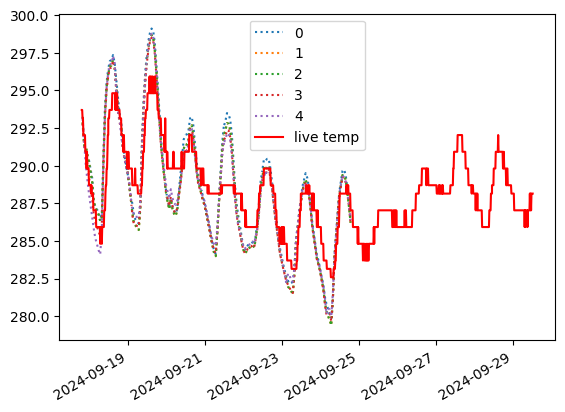

In [141]:
#plot the first 5 squares and the live temp
all_upsampled_temp_data[all_upsampled_temp_data.columns.drop('live_temp_k')[:5]].plot(label = [1,2,3,4], linestyle='dotted')
all_upsampled_temp_data['live_temp_k'].plot(c='red', label = 'live temp', linestyle='-')
plt.legend()
plt.show()


In [143]:
#the moment we've all been waiting for. Get corrs
corrs = all_upsampled_temp_data.corr()

<Axes: >

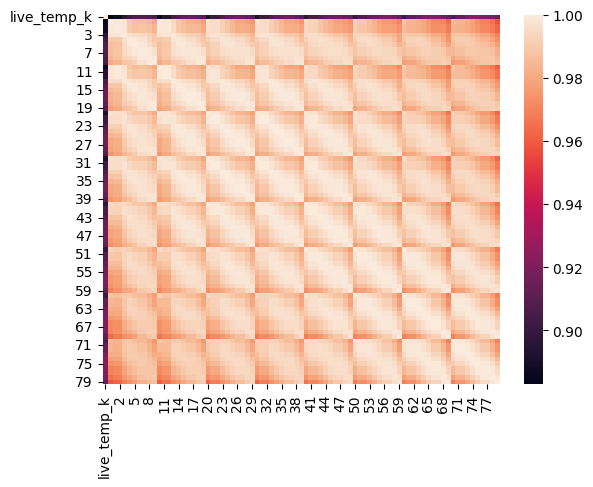

In [148]:
import seaborn as sns

sns.heatmap(corrs)

Text(0.5, 0, 'square number')

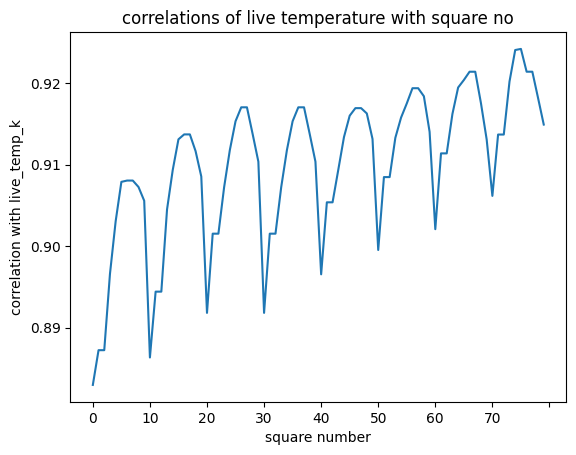

In [191]:
tcorrs = corrs['live_temp_k'].drop('live_temp_k')
tcorrs.plot()
plt.title('correlations of live temperature with square no')
plt.ylabel('correlation with live_temp_k')
plt.xlabel('square number')

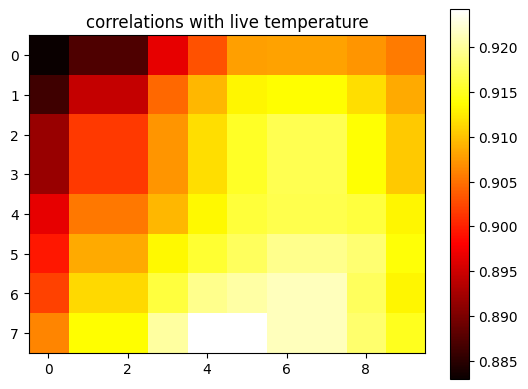

In [200]:
#at a glance, it looks like it's correlated with the middle-south of the image.
#let's arrange these on the map.

tcorrs_np = tcorrs.to_numpy().reshape((8,10))
plt.imshow(tcorrs_np, cmap='hot')
plt.colorbar()
plt.title('correlations with live temperature')
plt.show()

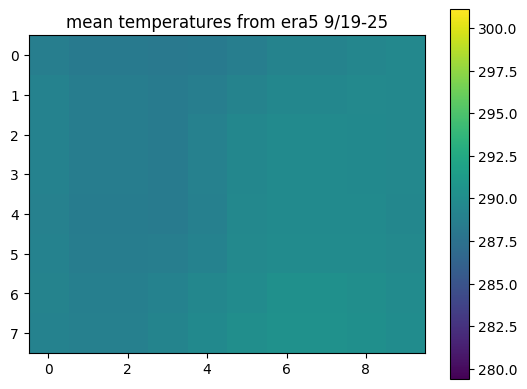

In [215]:
plt.imshow(src_data[1:].mean(axis=0), vmin = src_data[1:].min(), vmax=src_data[1:].max())
plt.title('mean temperatures from era5 9/19-25')
plt.colorbar();
plt.show()

In [238]:
map_center

[42.5, -72.768]

In [240]:
map_bounds

[array([ 42.23      , -72.96706488]), array([ 42.77      , -72.56893512])]

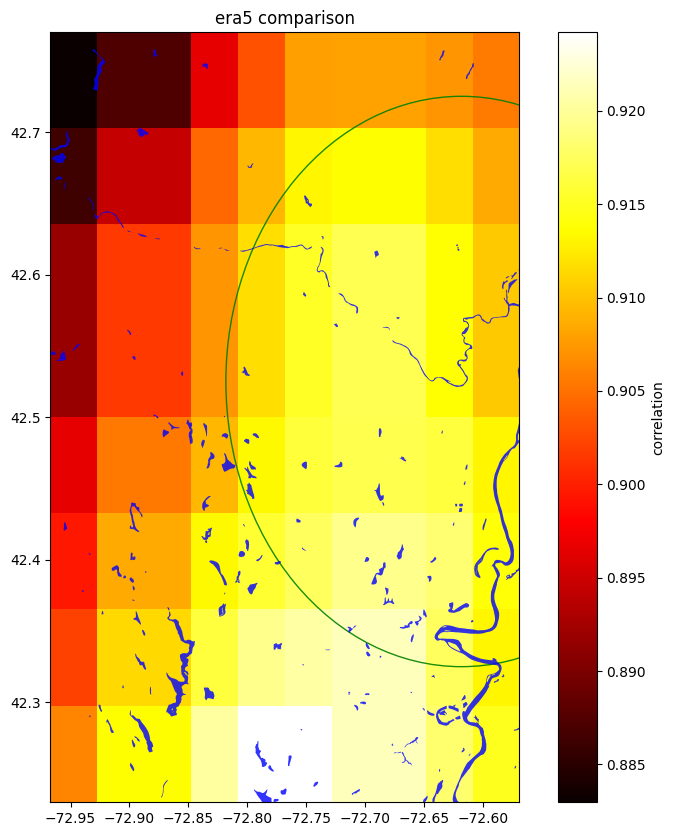

In [248]:
#this looks like the map from folium.


#let's overlay the correlations on this region.

import geopandas as gpd
from matplotlib.patches import Circle

#define the extent of the map. The original era5 data was given a 30 km radius,
#which is approx 0.27 degrees latitude. longitude probably 0.27*cos(lat)

map_center_np = np.array(list(reversed(map_center)))
map_widths = np.array([0.27*np.cos(np.deg2rad(42.5)), 0.27])

map_bounds = [
    map_center_np - map_widths,
    map_center_np + map_widths
]


waterways_shape_file = '../naturalearthdata/USA_Detailed_Water_Bodies.shp'
waterways = gpd.read_file(waterways_shape_file)

fig, ax = plt.subplots(figsize = (10, 10))


temps = ax.imshow(tcorrs_np, extent = [map_bounds[0][0], map_bounds[1][0],map_bounds[0][1], map_bounds[1][1]], cmap = 'hot')


ax.set_xlim(map_bounds[0][0], map_bounds[1][0])
ax.set_ylim(map_bounds[0][1], map_bounds[1][1])

#the final circle with diameter 27 mi is centered at at wapping, deerfield, ma
#this is a radius of 0.19 latitude
wapping = np.array([-72.6181665,42.5251015])
circle = Circle(wapping, 0.2, color = 'green', fill = False, alpha = 0.9)
ax.add_patch(circle)


waterways.plot(ax=ax, color = 'blue', linewidth=1, alpha = 0.8)

fig.colorbar(temps, ax=ax, orientation='vertical', label = 'correlation')

plt.title('era5 comparison')

plt.show()